# KNN Implemented From Scratch

Code is free of any AI-generation, is completely organic, GMO-Free, Pesticide free and has no added preservatives

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [562]:
N_CLASSES = 3

raw_data = [
    [150, 7.0, 1, 'Apple'],
    [120, 6.5, 0, 'Banana'],
    [180, 7.5, 2, 'Orange'],
    [155, 7.2, 1, 'Apple'],
    [110, 6.0, 0, 'Banana'],
    [190, 7.8, 2, 'Orange'],
    [145, 7.1, 1, 'Apple'],
    [115, 6.3, 0, 'Banana']
]

I choose to encode my training labels as one-hot because that makes it easier to calculate the label of test point by taking mode of its neighbours' labels (You can just sum up the labels of the k nearest neighbours and find the index with maximum value).

In [563]:
# Functions for one hot encoding/decoding

# Takes a label and returns one hot encoding in a tuple
def encode_one_hot(label):
    match label:
        case 'Apple': return [1, 0, 0]
        case 'Banana': return [0, 1, 0]
        case 'Orange': return [0, 0, 1]
        case _: return [0,0,0]

# Takes an integer and returns a label
def decode_class_index(class_index):
    match class_index:
        case 0: return 'Apple'
        case 1: return 'Banana'
        case 2: return 'Orange'
        case _: return "Unknown"

# Functions for calculating distances. 
# Takes in mxk and nxk input and returns an mxn matrix of distances, kind of like a proximity matrix
def minkowski_distance(a, b, p):

    a = a[:, np.newaxis, :]
    b = b[np.newaxis, :, :]

    return (abs(a-b)**p).sum(axis=2)**(1/p)

# Just special cases of Minkowski
def euclidean_dist(a, b):
    return minkowski_distance(a, b, 2)

def manhattan_dist(a, b):
    return minkowski_distance(a, b, 1)

# Accuracy function. Works for both, string labels and one-hot encoded labels.
def accuracy(predicted_label, true_label):
    if len(true_label.shape) == 1:
        return (predicted_label==true_label).sum()/true_label.shape[0]
    else:
        return (predicted_label==true_label).all(axis=1).sum()/true_label.shape[0]

In [564]:
# Data pre-processing (one-hot encoding the labels)
encoded_data = np.array(
    tuple((*data[:-1], *encode_one_hot(data[-1])) for data in raw_data)
)

# Splitting the features and the labels
X = encoded_data[:, :-3]
Y = encoded_data[:, -3:]

# Base Task

First, I have a simple implementation of KNN that only accomplishes what the base task asked for with no extra bells and whistles.

In [ ]:
# KNN Class definition
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.data = {"X": X, "y": y}

    def predict(self, X_test):
        # Calculate all the distances between every test and every training point at once.
        distances = euclidean_dist(X_test, self.data["X"])        

        # For every test point, Find the indices of K nearest neighbours in training set
        sorted_indices = np.argsort(distances, axis=1)[:, :self.k]  
        
        # Find the labels of the neighbours found in the previous step
        voters = self.data["y"][sorted_indices]                     

        # For every test point, Add up all the labels to essentially count votes for each possible label
        votes = voters.sum(axis=1)                                  

        # Mode of labels of K-nearest neighbours is just the one with max votes
        winners = np.argmax(votes, axis=1)                          

        # Decode all the class indices into strings
        predictions = [decode_class_index(winner) for winner in winners] 

        return predictions

In [566]:
test_data = np.array([
    [118, 6.2, 0],  # Expected: Banana
    [160, 7.3, 1],  # Expected: Apple
    [185, 7.7, 2]   # Expected: Orange
])

true_labels = np.array([
    "Banana",
    "Apple",
    "Orange"
])

model = KNN(k=3)
model.fit(X,Y)
predicted_label = model.predict(test_data)
print(predicted_label)
print("accuracy:", accuracy(predicted_label, true_label=true_labels))

['Banana', 'Apple', 'Orange']
accuracy: 1.0


# Testing different strategies. (Bonus Tasks)

We'll initialize different instances of the KNN with different strategies, and then compare their accuracy on an 80-20 split of the dataset over a range of values of K.

For this we'll define a better implementation of the KNN classifier with more options such as different distance metrics, weighted kNNs etc. 
Additionally we'll define a helper function to test the accuracy of a model

Note that I removed the color information because it had a 1 to 1 correspondance with the label and was causing all models to perform equally

In [567]:
class AdvancedKNN:
    def __init__(self, k, distance="Euclidean", weight=0, p=None):
        self.k = k
        self.weight = weight

        if p is None:
            match distance:
                case 'Euclidean': self.p = 2
                case 'Manhattan': self.p = 2
                case _: raise Exception("Unknown distance type")
        else:
            self.p = p

    def fit(self, X, y):
        self.data = {"X": X, "y": y}

    def predict(self, X_test):
        # Calculate all the distances between every test and every training point at once.
        distances = minkowski_distance(X_test, self.data["X"], p=self.p)
    
        # Find the index of K nearest neighbours in training set, for every test point
        sorted_indices = np.argsort(distances, axis=1)[:, :self.k]  

        # Find the labels of the neighbours found in the previous step
        voters = self.data["y"][sorted_indices].astype(np.float64)  
        
        # Calculate a weight for each voter by exponentiating the distance of that voter to the test point
        voter_distances = distances[np.repeat(np.arange(distances.shape[0]), self.k), sorted_indices.flatten()].reshape(sorted_indices.shape)
        weights = voter_distances**self.weight
        voters = weights[..., np.newaxis] * voters # Apply the weights

        # Add up all the labels to essentially count votes for each test point
        votes = voters.sum(axis=1)                                  

        # Mode of labels of K-nearest neighbours is just the max
        winners = np.argmax(votes, axis=1)                          

        # One hot encode the predicted labels again
        predictions = np.zeros((X_test.shape[0], self.data["y"].shape[1]))
        for i, winner in enumerate(winners): predictions[i, winner] = 1

        return predictions

In [568]:
def train_test_split(X, y, train_size=None, test_size=None, shuffle=True, random_state=42):
    if test_size is None:
        if train_size is None:
            train_size = 0.8
    else:
        train_size = 1-test_size

    indices = np.arange(X.shape[0])
    cutoff_index = int(train_size * X.shape[0])

    if shuffle: 
        np.random.seed(random_state)
        np.random.shuffle(indices)

    return X[indices[:cutoff_index]], X[indices[cutoff_index:]], y[indices[:cutoff_index]], y[indices[cutoff_index:]]

In [569]:
# New raw dataset from combining the given training and testing dataset
data = np.array([
    [150, 7.0, 1],
    [120, 6.5, 0],
    [180, 7.5, 2],
    [155, 7.2, 1],
    [110, 6.0, 0],
    [190, 7.8, 2],
    [145, 7.1, 1],
    [115, 6.3, 0],
    [118, 6.2, 0],  
    [160, 7.3, 1],  
    [185, 7.7, 2]   
])

true_label = np.array([encode_one_hot(label) for label in [
    'Apple',
    'Banana',
    'Orange',
    'Apple',
    'Banana',
    'Orange',
    'Apple',
    'Banana',
    "Banana",
    "Apple",
    "Orange",
]])

X_train, X_test, Y_train, Y_test = train_test_split(data[:-1], true_label, train_size=0.8, shuffle=True, random_state=42)

In [570]:
# Tests the given model's accuracy at different values of k
def Test(model, k_start=2, k_end=5):
    score = []

    for k in range(k_start, k_end+1):
        model.k = k
        model.fit(X_train,Y_train)
        score.append(
            accuracy(model.predict(X_test), Y_test)
        )

    return score

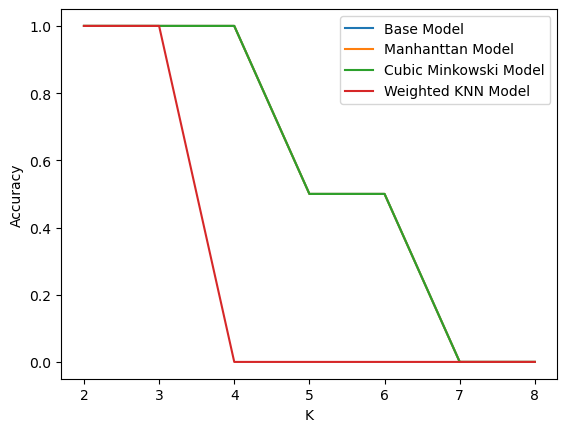

In [571]:
K_START = 2
K_END = 8

Base_Model = AdvancedKNN(k=3)
Base_Model_Score = Test(Base_Model, K_START, K_END)

Manhanttan_Model = AdvancedKNN(k=3, p=1)
Manhanttan_Model_Score = Test(Base_Model, K_START, K_END)

Cubic_Minkowski_Model = AdvancedKNN(k=3, p=3)
Cubic_Minkowski_Model_Score = Test(Cubic_Minkowski_Model, K_START, K_END)

Weighted_KNN = AdvancedKNN(k=3, weight=0.1)
Weighted_KNN_Score = Test(Weighted_KNN, K_START, K_END)

plt.figure()
plt.plot(np.arange(K_START, K_END+1), Base_Model_Score, label="Base Model")
plt.plot(np.arange(K_START, K_END+1), Manhanttan_Model_Score, label="Manhanttan Model")
plt.plot(np.arange(K_START, K_END+1), Cubic_Minkowski_Model_Score, label="Cubic Minkowski Model")
plt.plot(np.arange(K_START, K_END+1), Weighted_KNN_Score, label="Weighted KNN Model")
plt.xticks(np.arange(K_START, K_END+1))
plt.legend()
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

So yeah, it seems the dataset is too small to see any real difference in the performance of these differing techniques.
I didn't have time to find a good data set so.... yeah you're just gonna have to accept this.